In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas_profiling as pp

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
def plot_feature_importance(importance, columns, model_type=''):
    '''
    plots feature importances for given ml model
    '''

    importance_df = pd.DataFrame({'feature': columns,'importance': importance}).sort_values(by=['importance'], ascending=False)

    plt.figure(figsize=(10,8))
    sns.barplot(x=importance_df['importance'], y=importance_df['feature'])
    plt.title(model_type.upper() + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [3]:
def method_output(model):
    '''
    prints output - accuracy, precision, recall, f1 score and confusion matrix for given model 
    returns predictions for test set
    '''
    
    predict = model.predict(X_test)
    clf_conf_matrix = confusion_matrix(y_test, predict)
    clf_test_score = accuracy_score(y_test, predict)
    clf_train_score = accuracy_score(y_train, model.predict(X_train))
    clf_report_0 = pd.DataFrame.from_dict(classification_report(y_test, predict, output_dict=True)['0'], orient='index')[:3]
    clf_report_1 = pd.DataFrame.from_dict(classification_report(y_test, predict, output_dict=True)['1'], orient='index')[:3].rename(columns={0: 1})
    clf_report = pd.concat([clf_report_0, clf_report_1], axis=1).round(3)
    print('Test set confusion matrix:\n', clf_conf_matrix, '\n')
    print('Classification report:\n', clf_report, '\n')
    print('Test set accurancy score:\n', round(clf_test_score,3), '\n')
    print('Train set accurancy score:\n', round(clf_train_score,3), '\n')
    
    return predict

In [4]:
def roc_curve_plot(predictions):
    '''
    plots roc curves for given models 
    '''
    roc_values = {}
    for i in list(predictions.keys()):
        roc_values[f"{i}_false_positive_rate"] = roc_curve(y_test, predictions[i])[0]
        roc_values[f"{i}_true_positive_rate"] = roc_curve(y_test, predictions[i])[1]
    
    plt.figure(figsize=(16,8))
    plt.title('Reciver Operating Characterstic Curve')
    for i in range(0, len(roc_values.keys()), 2):
        plt.plot(roc_values[list(roc_values.keys())[i]], roc_values[list(roc_values.keys())[i+1]], label=models[int(i/2)])  
    plt.plot([0,1],ls='--')
    plt.plot([0,0],[1,0],c='.5')
    plt.plot([1,1],c='.5')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()
    plt.show()

In [5]:
def scores(predictions):
    '''
    returns accuracy, recall and AUC for given models
    '''
    scores = {}
    for i in list(predictions.keys()):
        scores[f"{i}"] = [round(accuracy_score(y_test, predictions[i]),3), 
                          round(float(pd.DataFrame.from_dict(classification_report(y_test, predictions[i], output_dict=True)['1'], orient='index').iloc[1]),3), 
                          round(roc_auc_score(y_test, predictions[i]),3)]
    
    return pd.DataFrame(scores, index=['accurancy_score', 'recall', 'auc_score']).sort_values(by=["accurancy_score", "recall"],axis=1, ascending=False)

In [6]:
heart = pd.read_csv('heart.csv')
heart.head();

In [7]:
pp.ProfileReport(heart);

In [8]:
heart.drop_duplicates(inplace=True)

In [9]:
pp.ProfileReport(heart);

In [10]:
heart[["sex", "cp", "fbs", "restecg", "exang", "slope", "thal", "target", "ca"]] = heart[["sex", "cp", "fbs", "restecg", "exang", "slope", "thal", "target", "ca"]].astype('category')

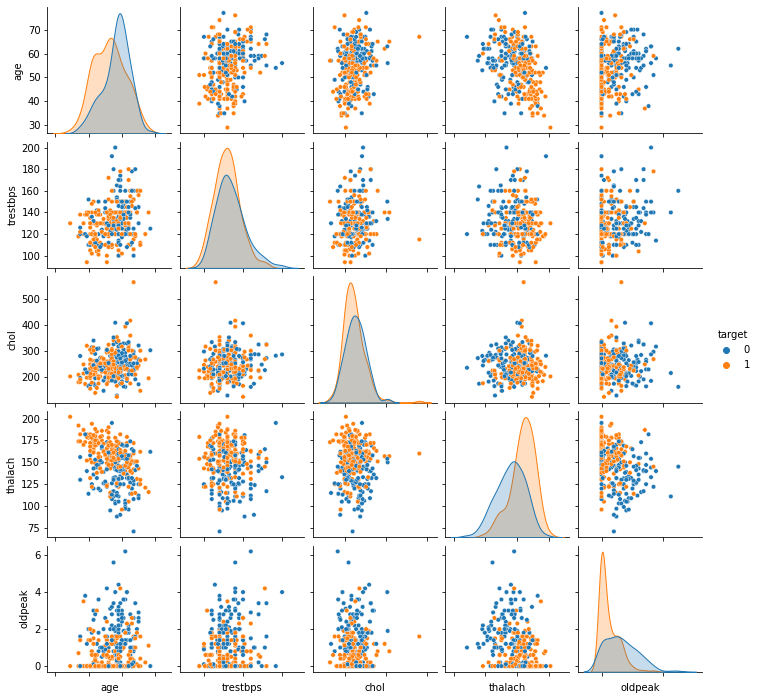

In [11]:
pp = sns.pairplot(heart, hue = 'target', height=2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=20) )
pp.set(xticklabels=[]);
pp.savefig("pairplot.png")

In [12]:
y = heart['target']
X = heart.drop('target', axis=1)
columns = list(X.columns)

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

predictions = {}
models_shortcuts = []
models = []

In [13]:
y_test.value_counts();

In [14]:
#k-nearest neighbors calssifier 
models_shortcuts.append('knn')
models.append('K nearest neighbors')
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
knn_predict = method_output(knn_clf)
predictions["knn"] = knn_predict

Test set confusion matrix:
 [[28  9]
 [ 3 36]] 

Classification report:
                0      1
precision  0.903  0.800
recall     0.757  0.923
f1-score   0.824  0.857 

Test set accurancy score:
 0.842 

Train set accurancy score:
 0.885 



Test set confusion matrix:
 [[30  7]
 [ 2 37]] 

Classification report:
                0      1
precision  0.938  0.841
recall     0.811  0.949
f1-score   0.870  0.892 

Test set accurancy score:
 0.882 

Train set accurancy score:
 0.858 



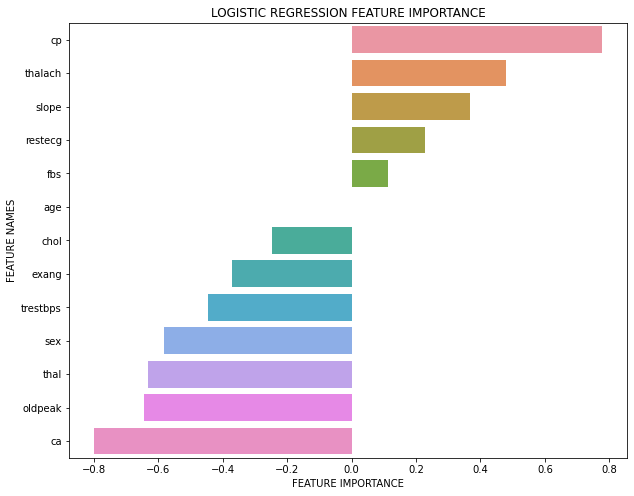

In [15]:
#logistic regression
models_shortcuts.append('lr')
models.append('Logistic regression')
lr_clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced')
lr_clf.fit(X_train, y_train)
lr_predict = method_output(lr_clf)
plot_feature_importance(lr_clf.coef_[0], columns, 'Logistic regression')
predictions["lr"] = lr_predict

Test set confusion matrix:
 [[28  9]
 [ 2 37]] 

Classification report:
                0      1
precision  0.933  0.804
recall     0.757  0.949
f1-score   0.836  0.871 

Test set accurancy score:
 0.855 

Train set accurancy score:
 0.96 



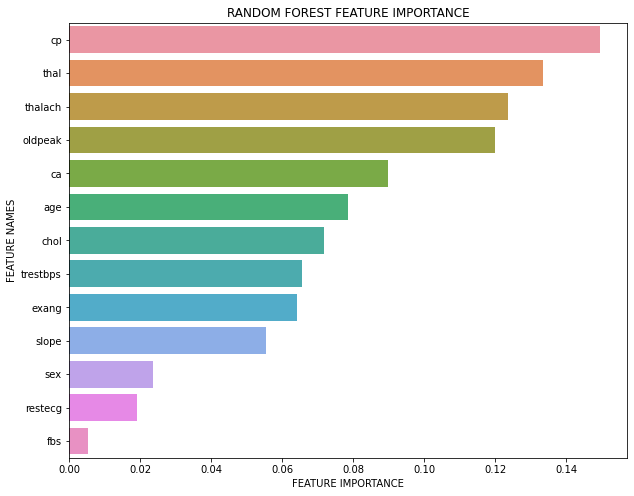

In [16]:
#random forest
models_shortcuts.append('rf')
models.append('Random forest')
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=4, max_depth=5)
rf_clf.fit(X_train, y_train)
rf_predict = method_output(rf_clf)
plot_feature_importance(rf_clf.feature_importances_, columns, 'Random forest')
predictions["rf"] = rf_predict

Test set confusion matrix:
 [[29  8]
 [ 2 37]] 

Classification report:
                0      1
precision  0.935  0.822
recall     0.784  0.949
f1-score   0.853  0.881 

Test set accurancy score:
 0.868 

Train set accurancy score:
 0.978 



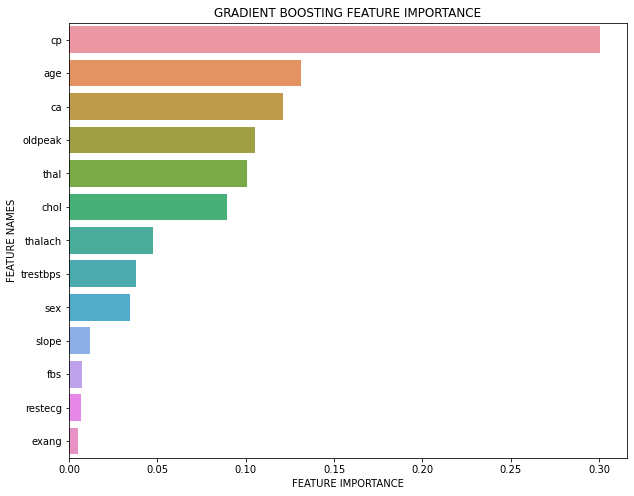

In [17]:
#Gradient Boosting
models_shortcuts.append('gb')
models.append('Gradient Boosting')
gb_clf = GradientBoostingClassifier(learning_rate=0.03, random_state=0, max_depth=5, n_estimators=40)
gb_clf.fit(X_train, y_train)
gb_predict = method_output(gb_clf)
plot_feature_importance(gb_clf.feature_importances_, columns, 'Gradient boosting')
predictions["gb"] = gb_predict

Test set confusion matrix:
 [[29  8]
 [ 2 37]] 

Classification report:
                0      1
precision  0.935  0.822
recall     0.784  0.949
f1-score   0.853  0.881 

Test set accurancy score:
 0.868 

Train set accurancy score:
 1.0 



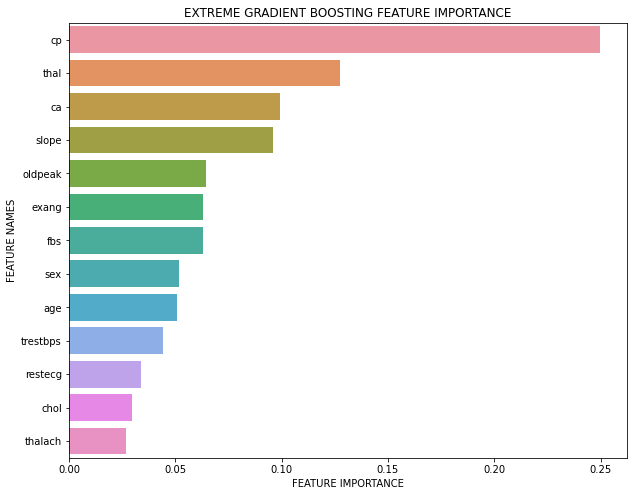

In [18]:
#Extreme Gradient Boosting
models_shortcuts.append('xgb')
models.append('Extreme Gradient Boosting')
xgb_clf = XGBClassifier(use_label_encoder=False, n_estimators=50, learning_rate=0.1, random_state=0, max_depth=5)
xgb_clf.fit(X_train, y_train, eval_metric='rmse')
xgb_predict = method_output(xgb_clf)
plot_feature_importance(xgb_clf.feature_importances_, columns, 'Extreme gradient boosting')
predictions["xgb"] = xgb_predict

In [19]:
#Support Vector Classification
models_shortcuts.append('svc')
models.append('Support Vector Classification')
svc_clf = SVC(gamma='auto', C=4)
svc_clf.fit(X_train, y_train)
svc_predict = method_output(svc_clf)
predictions["svc"] = svc_predict

Test set confusion matrix:
 [[30  7]
 [ 4 35]] 

Classification report:
                0      1
precision  0.882  0.833
recall     0.811  0.897
f1-score   0.845  0.864 

Test set accurancy score:
 0.855 

Train set accurancy score:
 0.965 



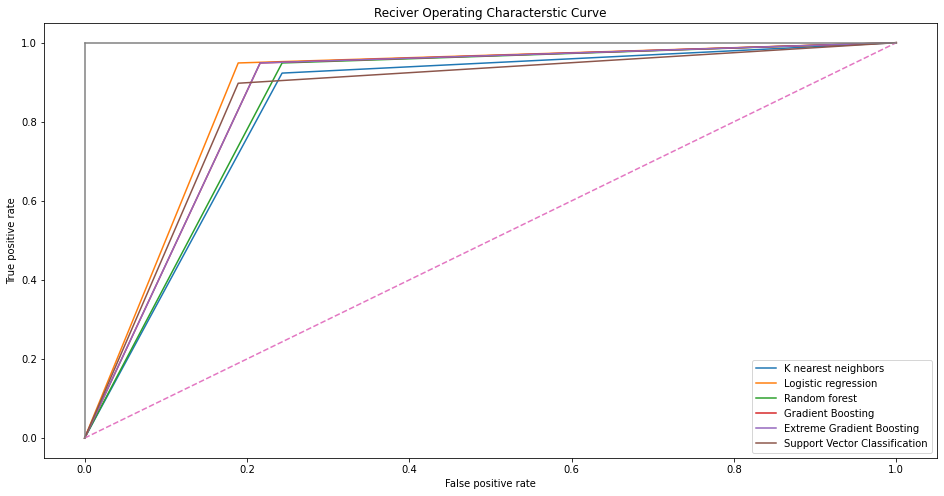

In [20]:
roc_curve_plot(predictions)

In [21]:
scores(predictions)

,lr,gb,xgb,rf,svc,knn
accurancy_score,0.882,0.868,0.868,0.855,0.855,0.842
recall,0.949,0.949,0.949,0.949,0.897,0.923
auc_score,0.880,0.866,0.866,0.853,0.854,0.840
